
Found 900 images belonging to 3 classes: ['Tomato_Early_Blight' 'Tomato_Healthy' 'Tomato_Leaf_Miner']
Train: (648, 384, 384, 3), Val: (72, 384, 384, 3), Test: (180, 384, 384, 3)
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.5762 - loss: 0.8531 - val_accuracy: 0.7917 - val_loss: 0.4645 - learning_rate: 0.0010
Epoch 2/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7449 - loss: 0.5264 - val_accuracy: 0.7639 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 3/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7450 - loss: 0.5190 - val_accuracy: 0.8611 - val_loss: 0.3632 - learning_rate: 0.0010
Epoch 4/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8189 - loss: 0.4535 - val_accuracy: 0.8750 - val_loss: 0.3078 - learning_rate: 0.0010
Epoch 5/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8012 - loss: 0.4753 - val_accuracy: 0.8750 - val_loss: 0.2796 - learning_rate: 0.0010
Epoch 6/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8100 - loss: 0.4650 - val_accuracy: 0.8889 - val_loss: 0.3230 - learning_rate: 0.0010
Epoch 7/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8333 - loss: 0.4086 - val_accuracy:

Model saved to: /content/drive/MyDrive/POC3_EfficientNetV2S.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.9115 - loss: 0.2224
Test Accuracy: 0.8999999761581421


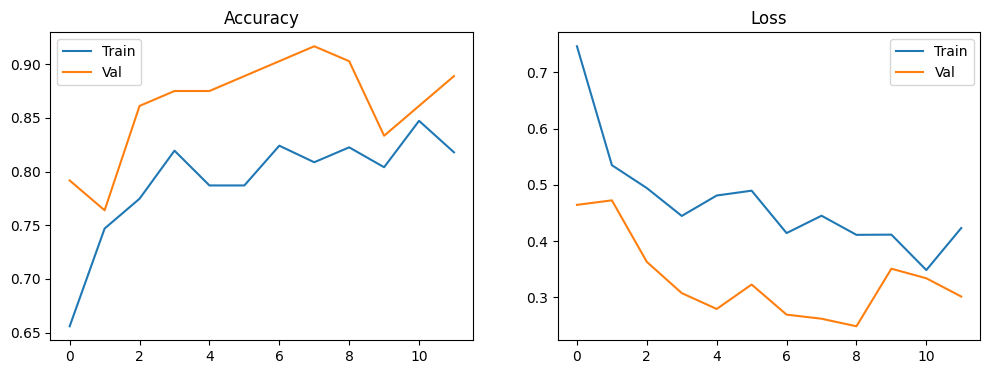

6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step


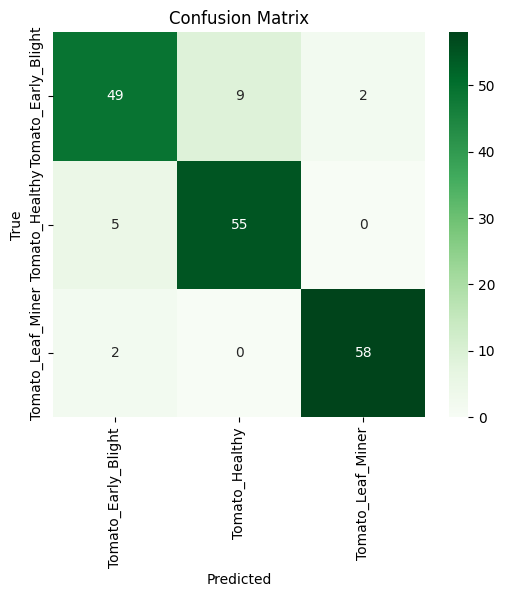


Classification Report:
                      precision    recall  f1-score   support

Tomato_Early_Blight       0.88      0.82      0.84        60
     Tomato_Healthy       0.86      0.92      0.89        60
  Tomato_Leaf_Miner       0.97      0.97      0.97        60

           accuracy                           0.90       180
          macro avg       0.90      0.90      0.90       180
       weighted avg       0.90      0.90      0.90       180



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


data_dir = '/content/drive/MyDrive/AgriVision_PoC'
img_size = (384, 384)
X, y = [], []

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img) / 255.0
                X.append(img_array)
                y.append(class_name)
            except Exception as e:
                print(f"Failed to process image {img_path}: {e}")

X = np.array(X)
y = np.array(y)


le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
num_classes = len(class_names)
print(f"\nFound {len(X)} images belonging to {num_classes} classes: {class_names}")


X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1, random_state=42, stratify=y_trainval
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")



train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
test_generator = val_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)



base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(384, 384, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-7)
]


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12,
    callbacks=callbacks,
    verbose=1
)


save_path = '/content/drive/MyDrive/POC3_EfficientNetV2S.h5'
model.save(save_path)
print("Model saved to:", save_path)


test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()


y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


print("\nClassification Report:\n",classification_report(y_test, y_pred_classes, target_names=class_names))



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save .tflite file
tflite_path = '/content/drive/MyDrive/POC3_EfficientNetV2S.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved to:", tflite_path)


Saved artifact at '/tmp/tmpllda8y26'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132921025947088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920652497744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920652497360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132921025947472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920652498704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920652497168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920652496976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920652498512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920652499088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920652499664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132920652498896